# Historical analysis on precipitation in Rotterdam 1974 - 2019

by: Sara Mendoza

Data Analytics - Ironhack Amsterdam / cohort Jan - June 2020

Project 4 - May 2020 // UPDATE Project 5 - June 2020

Update starts after point 10 - Conclusion


## 1 Introduction

In this notebook I analyze the daily rainfall measured in Rotterdam from 1974 to 2019.

The measured rainfall data can be found here: http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

More information on rain in the Netherlands quoted throughout this notebook can be found here: http://bibliotheek.knmi.nl/weerbrochures/FS_Regen.pdf

The file used has been stored in google drive, and can be downloaded from here: https://drive.google.com/drive/folders/1dhg49rF5hWF0_fBiGRtK_2niaw5Od5cA


### Target

Climate change is affecting rain patterns all over the world. In this notebook I try to analyze how the rain has been changing in Rotterdam over the last 50 years.


## 2 Importing libraries and reading the files

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# reading the files

station = pd.read_csv('../data/knmi_stations_2018.csv',sep=';')
rain = pd.read_excel('../data/KNMI_20200427.xlsx')

# station.head()
# rain.head()

## 2 Selecting and cleaning the data
Before I start analyzing the data, I need to select the information that I will use, change some of the data types and check for strange values

In [5]:
# cleaning blank spaces in columns and station names:
station.columns = station.columns.str.replace(" ","")
station['NAME'] = station['NAME'].str.replace(" ","")
rain.columns = rain.columns.str.replace(" ","")

# change Date data type to DATE
rain['YYYYMMDD'] = pd.to_datetime(rain['YYYYMMDD'].astype(int), format='%Y%m%d')

station.dtypes #all correct
rain.dtypes #all correct

# checking for blank values:
null_cols = station.isna().sum()
null_cols[null_cols > 0] # no blanks

#identifying RTM station CODE:
rtmstation = station[station['NAME'].isin(['ROTTERDAM'])]['STN']

#identifying rain information from RTM station
rtmrain = rain[(rain['#STN'] == 344)]

# checking for blank values in RTM:
null_cols = rtmrain.isna().sum()
null_cols[null_cols > 0] # has plenty of blanks, but I'll focus on certain columns only

# selecting relevant columns for precipitation analysis
# YYYYMMDD - Date
# DR - duration of precipitation (in 0.1 hours)
# RH - sum of precipitation for one day 
# RHX - highest recorded precipitation in one hour 

rtmrain = rtmrain[['YYYYMMDD','DR','RH','RHX']].reset_index()
rtmrain.drop('index',1,inplace=True)

# adding columns for month, year, semester, decade, etc. for plotting purposes 
rtmrain['month'] = pd.DatetimeIndex(rtmrain['YYYYMMDD']).month
rtmrain['year'] = pd.DatetimeIndex(rtmrain['YYYYMMDD']).year
rtmrain['quarter']= rtmrain['month'].apply(lambda x: math.floor((x-1)/3))
rtmrain['semester']= rtmrain['month'].apply(lambda x: math.floor((x-1)/6))
rtmrain['half_decade'] = (pd.DatetimeIndex(rtmrain['YYYYMMDD']).year)/5
rtmrain['half_decade']= rtmrain['half_decade'].apply(lambda x: math.floor(x))*5
rtmrain['decade'] = (pd.DatetimeIndex(rtmrain['YYYYMMDD']).year)/10
rtmrain['decade']= rtmrain['decade'].apply(lambda x: math.floor(x))*10

# checking for blank values in rtmrain:
null_cols = rtmrain.isna().sum()
null_cols[null_cols > 0] # has plenty of blanks

# it seems they only started measuring rainfall in 1974, so I will drop everything before that
rtmrain[6290:6315]

# Get indexes of rows with year before 1974
indexYear = rtmrain[rtmrain['year'] < 1974].index
 
# Delete these row indexes from dataFrame
rtmrain.drop(indexYear , inplace=True)

# reseting the index:
rtmrain = rtmrain.reset_index()
rtmrain.drop('index',1,inplace=True)

null_cols = rtmrain.isna().sum()
null_cols[null_cols > 0] # only two blanks now

#first index we change to 76 as it has a similar rainy pattern as another day
#second index is zero all round
ind_nan = rtmrain[(rtmrain['DR'].isna() == True)].index
rtmrain['DR'][ind_nan[0]] = 76
rtmrain['DR'][ind_nan[1]] = 0
null_cols = rtmrain.isna().sum()
null_cols[null_cols > 0] # zero blanks now
# computer doesnt seem to like my way of changing the data, its giving me a warning, 
# but I tried different ways with the same result, and it seems to work anyway.

# DR - duration of precipitation (in 0.1 hours), I want to change this to real hours and minutes:
rtmrain['Total precip in hours'] = rtmrain['DR']/10
rtmrain['Total precip in min'] = rtmrain['Total precip in hours']*60

# columns RH & RHX use "-1" to indicate less than 0.5 mm , I prefer 0.25, as otherwise totals will be inconsistent
rtmrain['RH'] = rtmrain['RH'].replace(-1,0.25)
rtmrain['RHX'] = rtmrain['RHX'].replace(-1,0.25)

#changing column names to make them easier to read
rtmrain = rtmrain.rename(columns={'YYYYMMDD': 'Date', 'RH': 'total_precip/day', 'RHX': 'max_preciphour'})

# looking at outliers for possible mistakes in data
q = rtmrain["DR"].quantile(0.99)
rtmrain[rtmrain["DR"] > q].sort_values(by = 'DR')

q = rtmrain["total_precip/day"].quantile(0.99)
rtmrain[rtmrain["total_precip/day"] > q].sort_values(by = 'total_precip/day')

q = rtmrain["max_preciphour"].quantile(0.99)
rtmrain[rtmrain["max_preciphour"] > q].sort_values(by = 'max_preciphour')

# I think it looks OK, only date 1975-06-23 looks a bit out there, but according to online resources,
# there was a strange snow-spell in UK, in these dates in June?
# https://www.birminghammail.co.uk/news/midlands-news/snow-scenes-june-1975---9375720
# https://www.netweather.tv/forum/topic/29533-june-1975-snow-in-june/
# https://www.theweatheroutlook.com/twoother/twocontent.aspx?type=tystat&id=760

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [int32]

## 3 Creating a new clasification
Rain measured in mm can be a bit abstract, one millimeter of rainfall is the equivalent of one liter of water per square meter. Yet how much is a lot of rain? I found the following clasification from wikipedia and will add it to my data set:

Light rain: < 2.5 mm per hour

Moderate rain: between 2.5 mm to 7.6 mm per hour

Heavy rain: between 7.6 mm to 50 mm per hour

Violent rain: > 50 mm per hour

clasification from https://en.wikipedia.org/wiki/Rain#Measurement


In [6]:
# function to identify the maximum precipitation recorded in one hour and add classification
def raintype(s):
    if s['max_preciphour'] == 0:
        return '0 dry'
    elif (s['max_preciphour'] > 0) & (s['max_preciphour'] <= 2.5):
        return '1 light'
    elif (s['max_preciphour'] > 2.5) & (s['max_preciphour'] <= 7.6):
        return '2 moderate'
    elif (s['max_preciphour'] > 7.6) & (s['max_preciphour'] <= 50):
        return '3 heavy'
    else:
        return '4 violent'
    
rtmrain['raintype'] = rtmrain.apply(raintype, axis=1)

rtmrain.head()

,Date,DR,total_precip/day,max_preciphour,month,year,quarter,semester,half_decade,decade,Total precip in hours,Total precip in min,raintype
0,1974-01-01,0.0,0.0,0.0,1,1974,0,0,1970,1970,0.0,0.0,0 dry
1,1974-01-02,0.0,0.0,0.0,1,1974,0,0,1970,1970,0.0,0.0,0 dry
2,1974-01-03,0.0,0.0,0.0,1,1974,0,0,1970,1970,0.0,0.0,0 dry
3,1974-01-04,30.0,7.0,5.0,1,1974,0,0,1970,1970,3.0,180.0,2 moderate
4,1974-01-05,21.0,12.0,7.0,1,1974,0,0,1970,1970,2.1,126.0,2 moderate


## 4 Total rainy days per year
The first thing I was curious about was the amount of rainy days per year and weather this amount has increased or decreased over the years

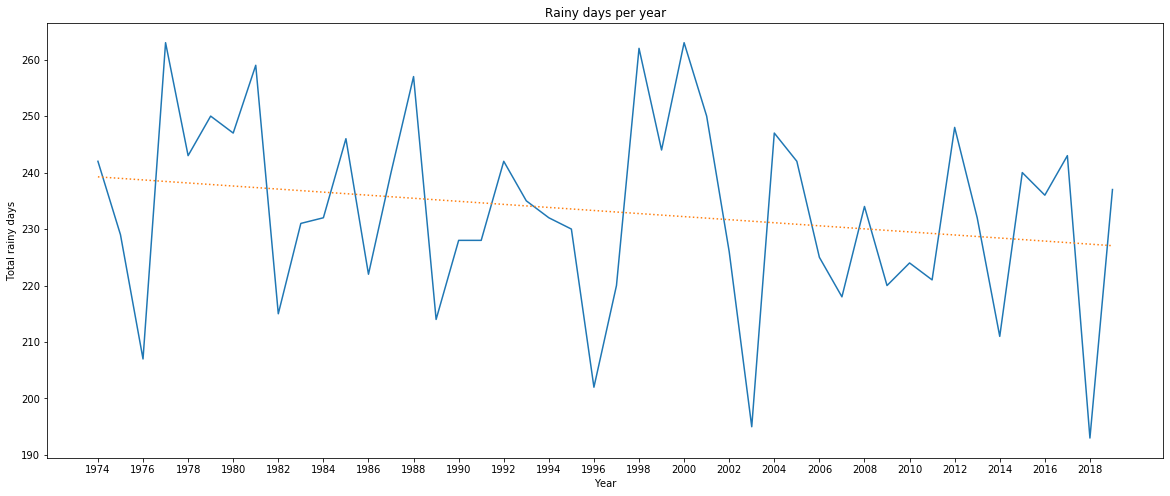

In [7]:
# counting total rainy days per year 
# removing 2020 as the year is not complete
wetdays = rtmrain[(rtmrain['raintype'] != '0 dry') & (rtmrain['year'] != 2020)]
wetdays = wetdays.groupby(['year'])['raintype'].count()

#plotting
plt.figure(figsize=(20, 8))
plt.title('Rainy days per year')

x = np.arange(0, len(wetdays)) # amount of years to plot
xrange = np.arange(0, len(wetdays), 2) # for labeling

coef = np.polyfit(x, wetdays, 1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, wetdays)
plt.plot(x, poly1d_fn(x), ls=":")

plt.xticks(xrange, np.arange(1974, 2020,2))

plt.xlabel('Year')
plt.ylabel('Total rainy days')
#plt.savefig('../images/1totalrainydays.png')
plt.show()


The amount of rainy days per year ranges between 200 and 260. It appears to be a bit cyclical with 2 to 3 years of rain and then a drier year with around 50 less days of rain. In general the trend seems to be in decline, with the last few years having less rainy days than 50 years ago.

## 5 Amount of rain during a rainy day
So we are seing a decline on rainy days per year, but how much rain does each rainy day have, and how has this changed

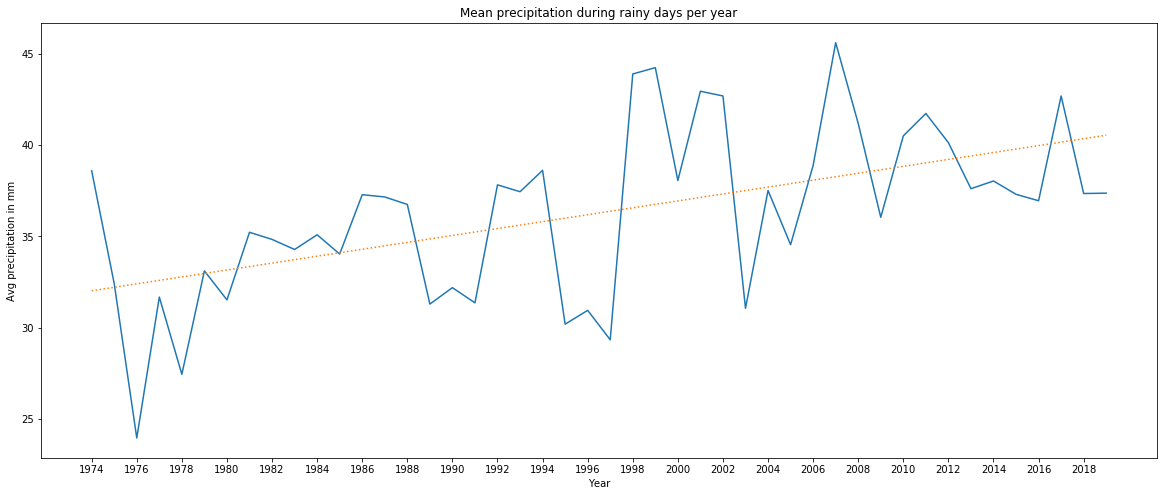

In [8]:
#removing 2020 as the year is not complete
rtmrainmean = rtmrain[(rtmrain['raintype'] != '0 dry') & (rtmrain['year'] != 2020)]

#calculating mean per year
rtmrainmean = rtmrainmean.groupby(['year'])['total_precip/day'].mean()

#plotting
plt.figure(figsize=(20, 8))
plt.title('Mean precipitation during rainy days per year')

x = np.arange(0, len(rtmrainmean)) # amount of years to plot
xrange = np.arange(0, len(rtmrainmean), 2) # for labeling

coef = np.polyfit(x, rtmrainmean, 1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, rtmrainmean)
plt.plot(x, poly1d_fn(x), ls=":")


plt.xticks(xrange, np.arange(1974, 2020,2))

plt.xlabel('Year')
plt.ylabel('Avg precipitation in mm')
#plt.savefig('../images/2meanrain.png')
plt.show()


So even if the amount of rainy days has decreased, we can see that in average the amount of rain during each rainy day has increased. 

According to the KNMI (The Royal Netherlands Meteorological Institute) this is due to climate change. They have observed data from all over the country in the last 100 years, and estimate an increase of 25% of precipitation. This increase, they have noted, is partialy due to the warmer summer months we are having, where the warm air causes more waterdamp in the air.

## 6 Rain per semester
As per the KNMI most of the increase in precipitation over the last few years is in the second half of the year, so I wanted to check if I could find the same in my data.

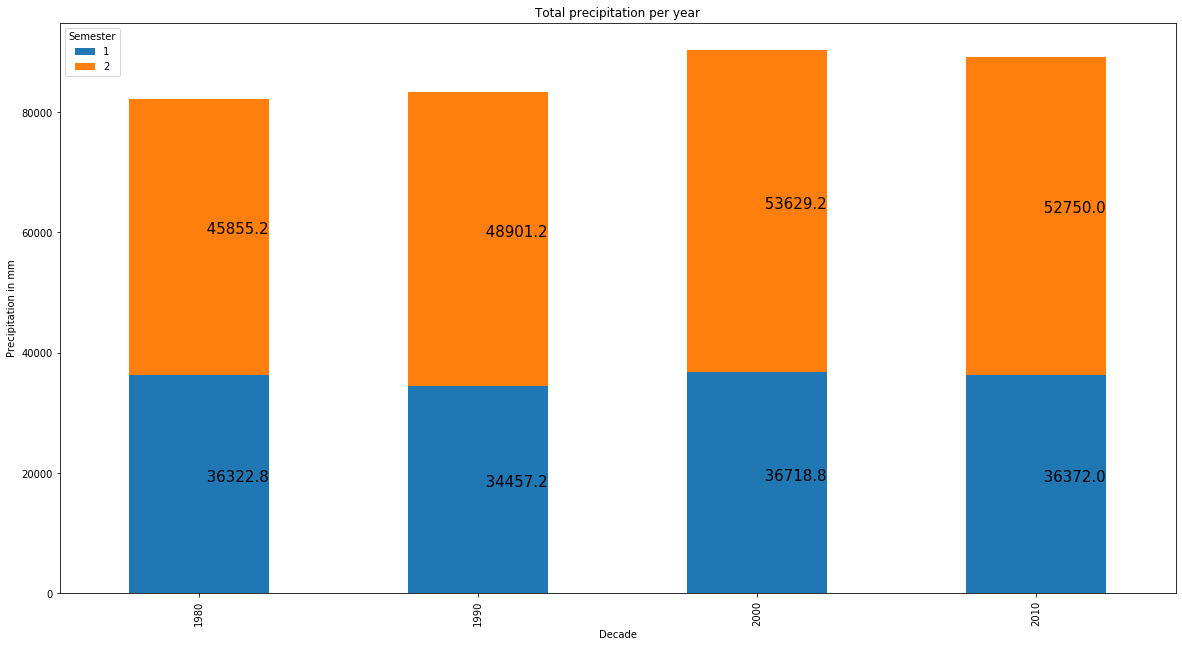

In [9]:
# total per decade (show semesters)

# removing first and last decade as they are not 10 year info:
decades = rtmrain['decade'].unique()
decades = decades[1:-1]
stackedrain = rtmrain[rtmrain['decade'].isin(decades)]
stackedrain = stackedrain.pivot_table(index=['decade'],columns=['semester'],values=['total_precip/day'], aggfunc=sum)


ax = stackedrain.plot(kind='bar', stacked=True, figsize=(20, 10.5))
ax.set_title('Total precipitation per year')
ax.set_xlabel('Decade')
ax.set_ylabel('Precipitation in mm')
ax.set_label(stackedrain['total_precip/day'])
plt.legend((1,2,3,4), loc = "upper left",title="Semester")

# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height : .1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width  # adjust 0.2 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='bottom', fontsize=15)
#plt.savefig('../images/3rainsemester.png')
plt.show()


In the last 4 decades we can observe that the amount of rain in the 1st semester of the year remains very stable, with even last decade 2010 having the same amount of precipitation that in the 80's (36.3 thousand mm of rain).

During the second half of the year, however, we note an increase  in precipitation of 7 thousand mm in the course of the 4 decades.

## 7 Total precipitation per month
I wanted to look closer at the data and try to identify and changes or trends per month for the last 4 decades

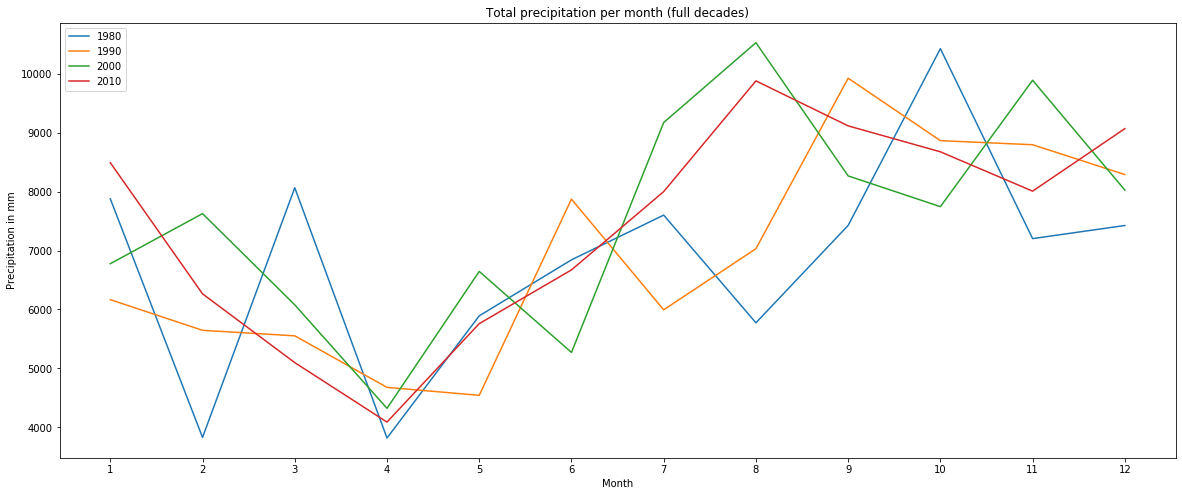

In [10]:
raindecade = rtmrain[rtmrain['decade'].isin(decades)]
raindecade = raindecade.pivot_table(index=['month'],columns=['decade'],values=['total_precip/day'], aggfunc=sum)

plt.figure(figsize=(20, 8))
plt.title('Total precipitation per month (full decades)')
plt.plot(raindecade)
plt.xticks(np.arange(1, 13, 1))
plt.xlabel('Month')
plt.ylabel('Precipitation in mm')
plt.legend((decades), loc = "upper left")
#plt.savefig('../images/4totalpermonth.png')
plt.show()


Its interesting to see that in the 80's, the month with most precipitation was October, in the 90's it was September and in 2000 and 2010 it is August. It seems every decade brought the peak a month earlier.
From April to June, the amount of precipitation seems very similar for all 4 decades, but its in the summer months (July and August specifically) where we see the biggest differece, where the 2 oldest decades remain low, and the most recent decade go up in precipitation,leaving a glaring gap of difference.

## 8 Rain type patterns
We have observed so far that its not the rainy days that have increased over the years, but rather the amount of rain that falls when it does rain. With this plot I wanted see what rain clasifications have increased over the years.

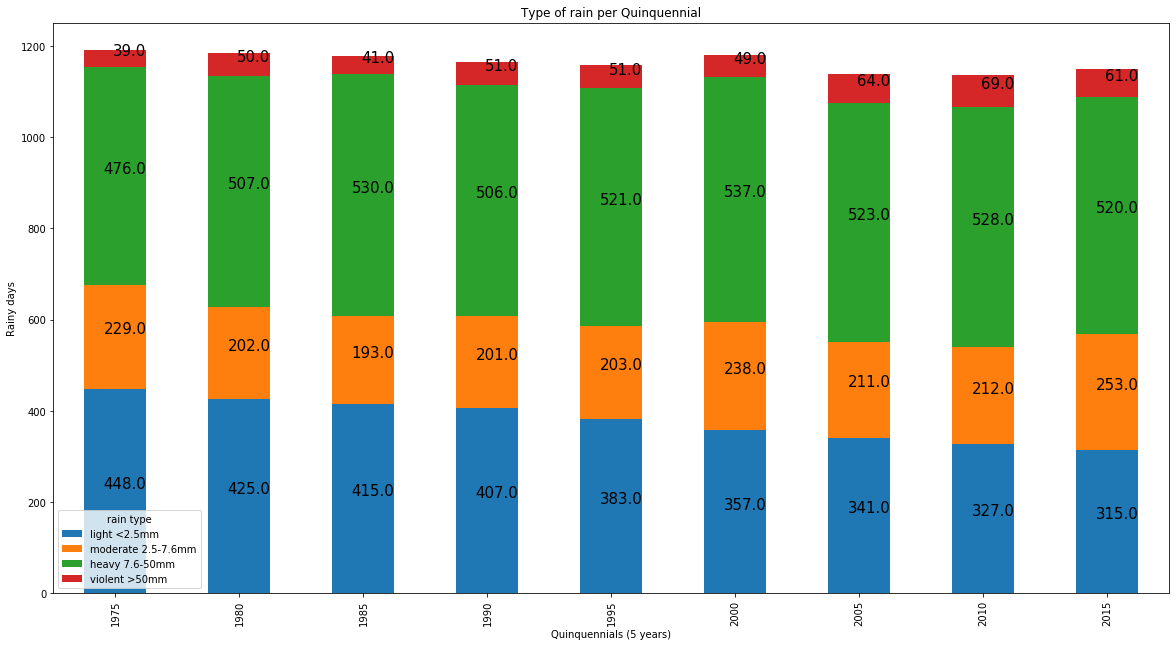

In [11]:
# removing first and last half_decade as they are not 5 year info:
half_decades = rtmrain['half_decade'].unique()
half_decades = half_decades[1:-1]

rtmraintype = rtmrain[rtmrain['half_decade'].isin(half_decades)]

#selecting only heavy rain
rtmraintype = rtmraintype[rtmraintype['raintype'].isin(['1 light','2 moderate', '3 heavy', '4 violent'])]
rtmraintype = rtmraintype.pivot_table(index=['half_decade'],columns=['raintype'],values=['max_preciphour'], aggfunc=len)

ax = rtmraintype.plot(kind='bar', stacked=True, figsize=(20, 10.5))

ax.set_title('Type of rain per Quinquennial')
ax.set_xlabel('Quinquennials (5 years)')
ax.set_ylabel('Rainy days')
plt.legend(('light <2.5mm','moderate 2.5-7.6mm', 'heavy 7.6-50mm', 'violent >50mm'), loc = "lower left",title="rain type")
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width  # adjust 0.2 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='bottom', fontsize=15)

#plt.savefig('../images/5typeofrain.png')
plt.show()


The trend shows that while light rain days have been decreasing, heavy and violent rain days have increased

## 9 Rain profile for RTM, based on the last 5 years
Finally, based on the precipitation of the last 5 years, I wanted to create a profile to know what I could expect in the comming months for rain in Rotterdam

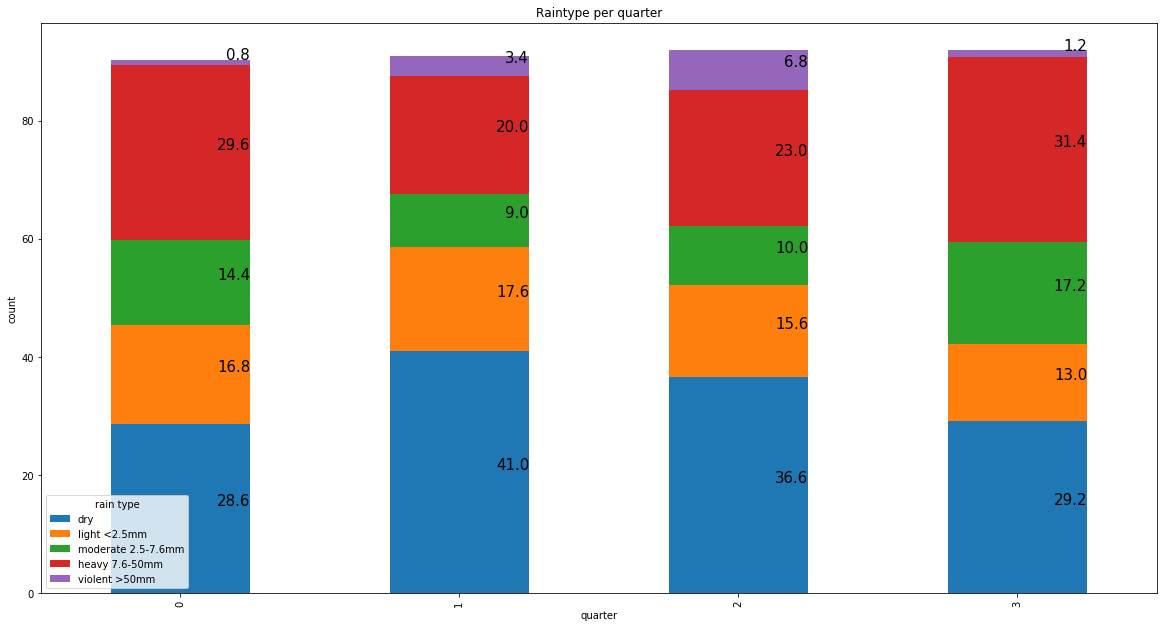

In [12]:
# checking last 5 years
raintype_quarter = rtmrain[rtmrain['year'].isin(['2019', '2018', '2017', '2016','2015'])]

raintype_quarter = raintype_quarter.pivot_table(index=['quarter'],columns=['raintype'],values=['max_preciphour'], aggfunc=len)

raintype_quarter = raintype_quarter/5

ax = raintype_quarter.plot(kind='bar', stacked=True, figsize=(20, 10.5))

ax.set_title('Raintype per quarter')
ax.set_xlabel('quarter')
ax.set_ylabel('count')
plt.legend(('dry','light <2.5mm','moderate 2.5-7.6mm', 'heavy 7.6-50mm', 'violent >50mm'), loc = "lower left",title="rain type")
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width  # adjust 0.2 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='bottom', fontsize=15)

#plt.savefig('../images/6raintypequarter.png')
plt.show()


The first and last quarter of the year seem to have the most heavy rainfalls, but the summer has the most violent rainfalls of the year. Our current quarter (1 April - June) seems to be the best quarter of the year with the most dry days and most light rain days. 

In the plot below we also see that during the first and last quarter of the year we can expect rainfalls to last around 3 hours (with some terrible exceptions of over 20 hours), while the 2 middle quarters have a smaller average of around 1 hour per rain for each precipitation.

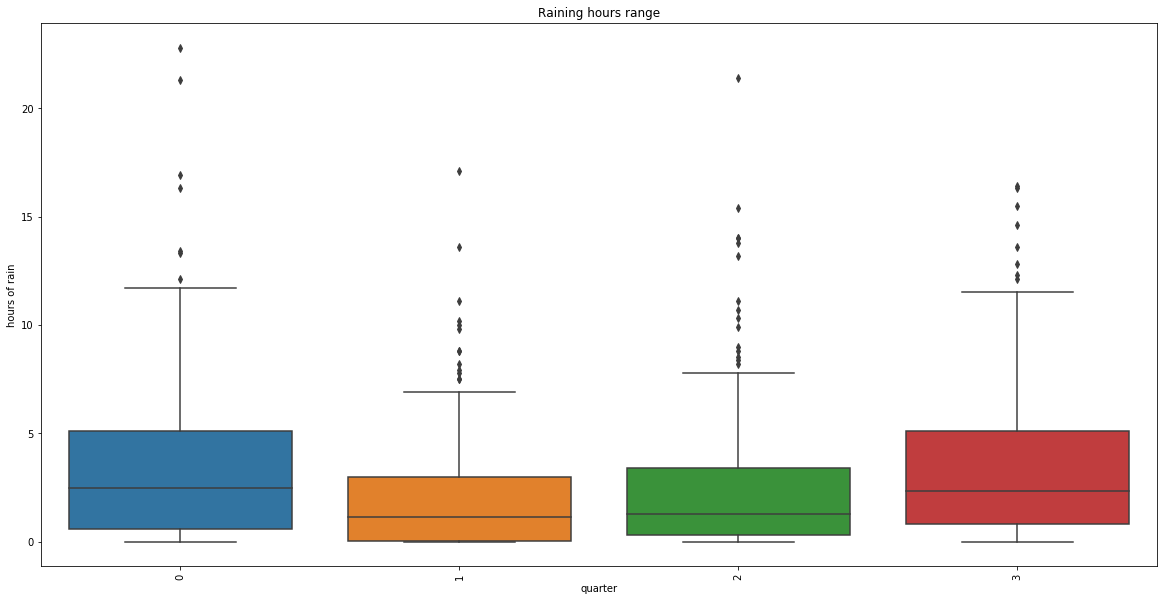

In [13]:
#removing 2020 as the year is not complete
durationquarter = rtmrain[rtmrain['raintype'] != '0 dry']

durationquarter = durationquarter[durationquarter['year'].isin(['2019', '2018', '2017', '2016','2015'])]

plt.figure(figsize=(20, 10))
g = sns.boxplot(x='quarter', y='Total precip in hours', data=durationquarter)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

g.set_xlabel("quarter")
g.set_ylabel("hours of rain")
g.set_title('Raining hours range')
#plt.savefig('../images/7rainingrange.png')
plt.show()


## 10 Conclusion
Rain patterns in RTM have been shifting from 1974 to today. We notice less rainy days, but harder rainfalls when it does rain. Notabily also an increase in violent rainfalls (which means more than 50 lites of water per square meter during an hour). 

We notice that the first half of the year remains quite stable over the decades, but its the second half, specifically around the summer months where the rain patterns are shifting. According to the KNMI this is due to the increase in temperature. Warmer summer months increase the waterdamp in the air and create more rainfalls.

The KNMI has created 6 predictions for the future, but in all of them they expect the amount of violent rainfalls to keep increasing and amount of days with rain to decrease, specially in the summer.

Its hard to say what effect this will have on our planet, but my grandfather will definitely not be happy as heavy rainfalls ruin his garden, and light rains are the best for his vegetables!!

## Comments Paolo

Sara, good story! Great notebook, very nicely structured with good introduction and background explanations. All the sections are organized and well commented both in code and markdown.
The plots are clear and based on the message you want to convey.
The source of the data is indicated and the location of the data is well linked.

A few ideas/suggestions

- In the first part when you do the data cleaning consider breaking that big cell into a few smaller   ones. That way the steps are easier to check, for you in the future or someone else working with you on this project
- The trends you describe with the green dotted lines I think are there although for the first one the data are quite noisy. You could go one step further and do a linear regression checking fit parameters and significance of the values. You could also try to implement a real prediction splitting the data in train and test set and see how good the prediction is on the test set.
- It depends on who your stakeholders may be on this project but you could consider making your conclusion section even more quantitative sumarizing the data from the plots. 
- The size of fonts and labels are fine for viewing the plots while reading the notebook but in general too small if you copy paste the plots for a presentation.
- I commented out the part where you save the images because otherwise I would get an error (because I dont have the images folder). But you have the right approach with the images folder with relative path. What you could do is at the beginning of the notebook asking if the user wishes to save the images and add the saving part in a if-statement, stating also that they would be saved in the ../images folder.

## Project 5 - ML and predictions

Update on project 4, adding ML models

In this project I will try to create models to be able to predict, on basis of the weather, the season. And on basis of all weather data except any rain measurements, if its a rainy day or not.

## 2.1 Loading the data and cleaning it

As I only used the rain data for the last project, I'm reloading the entire data set again and cleaning it.

In [14]:
# creating new data frame as this time I want to keep more info than just the rain info

#identifying weather information from RTM station
rtmrainmodel = rain[(rain['#STN'] == 344)]

# adding columns for clasification
rtmrainmodel['month'] = pd.DatetimeIndex(rtmrainmodel['YYYYMMDD']).month
rtmrainmodel['year'] = pd.DatetimeIndex(rtmrainmodel['YYYYMMDD']).year

# Get indexes of rows with year before 1994, as this is when they started to record all weather data
indexYear = rtmrainmodel[rtmrainmodel['year'] < 1994].index

# Delete these row indexes from dataFrame
rtmrainmodel.drop(indexYear , inplace=True)

# reseting the index:
rtmrainmodel = rtmrainmodel.reset_index()
rtmrainmodel.drop('index',1,inplace=True)

In [15]:
# there are 24 rows missing at least one attribute. 
null_cols = rtmrainmodel.isna().sum()
null_cols[null_cols > 0] 

# as the missing data is not consecutive I will drop it. I don't think it will be bad if a month is missing a day
rtmrainmodel[rtmrainmodel.isna().any(axis=1) == True]
rtmrainmodel.dropna(inplace = True)
rtmrainmodel.reset_index(inplace=True)

Adding information on the seasons. According to the Northern Meteorological Seasons definition, the seasons begin on the first day of the months that include the equinoxes and solstices:

Spring runs from March 1 to May 31; 

Summer runs from June 1 to August 31;

Fall   runs from September 1 to November 30;

Winter runs from December 1 to February 28.

https://www.timeanddate.com/calendar/aboutseasons.html

In [16]:
# function to identify the season
def season(s):
    if (s['month'] > 2) & (s['month'] <= 5):
        return 1
    elif (s['month'] > 5) & (s['month'] <= 8):
        return 2
    elif (s['month'] > 8) & (s['month'] <= 11):
        return 3
    else:
        return 4
    
rtmrainmodel['season'] = rtmrainmodel.apply(season, axis=1)
rtmrainmodel[rtmrainmodel.isna().any(axis=1) == True]

# check to ensure the classification is correct:
# rtmrain.pivot_table(index=["season","month"], values=["DR"], aggfunc= np.sum)

,index,#STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,...,NG,UG,UX,UXH,UN,UNH,EV24,month,year,season


## 2.2 Preparing the data for the machine learning model

I will check which data I need to keep, and which is redundant and can be removed

In [17]:
# dropping the first 2 columns as I dont need the station (always RTM) and the date is also unnecesary
rtmrainmodel.drop(['#STN','YYYYMMDD'],1,inplace=True) 

# checking data types as all must be numeric
rtmrainmodel.dtypes

index       int64
DDVEC     float64
FHVEC     float64
FG        float64
FHX       float64
FHXH      float64
FHN       float64
FHNH      float64
FXX       float64
FXXH      float64
TG        float64
TN        float64
TNH       float64
TX        float64
TXH       float64
T10N      float64
T10NH     float64
SQ        float64
SP        float64
Q         float64
DR        float64
RH        float64
RHX       float64
RHXH      float64
PG        float64
PX        float64
PXH       float64
PN        float64
PNH       float64
VVN       float64
VVNH      float64
VVX       float64
VVXH      float64
NG        float64
UG        float64
UX        float64
UXH       float64
UN        float64
UNH       float64
EV24      float64
month       int64
year        int64
season      int64
dtype: object

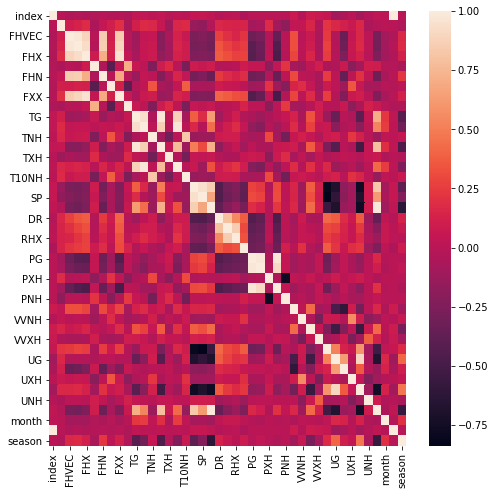

In [18]:
# now I'll check for Column collinearity
corr = rtmrainmodel.corr()
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(corr)


In [21]:

# Highly correlated:
# EV24 & Q / dropping EV24
# TN & T10N & T10N / dropping T10NH & T10N 
# TG & TX / dropping TX
# PN & PG / dropping PN
# PX & PG / dropping PX
# FG & FHVEC / dropping FHVEC
# FHX & FXX / dropping FXX
# SP & SQ / dropping SP
# TN & TG / dropping TN
# FG & FHX / dropping FHX
# UN & UG / dropping UN

rtmrainmodel.drop(['EV24','T10NH','TX','T10N','PN','PX','FHVEC','FXX','SP','TN','FHX','UN'],1,inplace=True) 
rtmrainmodel.corr()

df = pd.DataFrame(rtmrainmodel)

c = df.corr().abs()

s = c.unstack()
so = s.sort_values(ascending=False)

print(so[25:50])
# all correlations >.90 have been removed



KeyError: "['EV24' 'T10NH' 'TX' 'T10N' 'PN' 'PX' 'FHVEC' 'FXX' 'SP' 'TN' 'FHX' 'UN'] not found in axis"

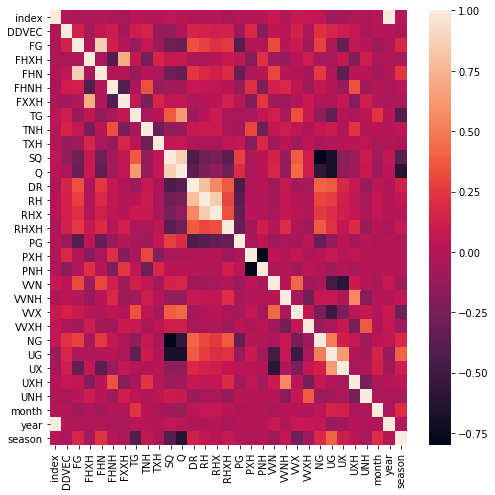

In [20]:
corr = rtmrainmodel.corr()
sns.heatmap(corr)
plt.rcParams["figure.figsize"] = (12,12)

## 2.3 Scaling the data
As we have a lot of columns with very divers information that has been quantified diferently, its important to scale the data, this way all columns will have an equal value 

In [22]:
#scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_rtmrainmodel = scaler.fit_transform(rtmrainmodel)
scaled_rtmrainmodel = pd.DataFrame(scaled_rtmrainmodel)
scaled_rtmrainmodel

# updating column names
namesList = rtmrainmodel.columns
scaled_rtmrainmodel.columns = namesList

scaled_rtmrainmodel['season'] = rtmrainmodel['season']

#scaled_rtmrainmodel

## 2.4 Predicting the season
I will attempt to predict the season, as this data is labeled this will be a supervised machine learning model. I will use 2 different models to see which one is most effective:
1) Logistic Regression

2) k-nearest neighbors

In [23]:
from sklearn.model_selection import train_test_split

#first we divide the train and test data

y = scaled_rtmrainmodel['season']
X = scaled_rtmrainmodel.drop(['season','month'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [24]:
from sklearn.linear_model import LogisticRegression

#here we build, fit and use the model

model = LogisticRegression()

model.max_iter = 300

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
8788,4,4
6779,2,2
2743,2,3
2279,1,1
3561,3,3
...,...,...
928,2,2
6230,4,4
3108,2,2
2457,3,3


supervised learning has the advantaged that you can measure the accuracy, so its easier to compare models. This logistic regression model has returned a score of 0.83 which is fairly high, but could be better

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(y_test, y_pred) # score: 0.83220

confusion_matrix(y_test, y_pred)

array([[367,  51,  20,  25],
       [ 37, 416,  17,   0],
       [ 11,  32, 393,  59],
       [ 19,   0,  28, 444]], dtype=int64)

the confusion matrix here is more complicated than a normal one because there are 4 different categories, the true positives are in the diagonal top left to bottom right, the rest are incorrect classifications. The first classification (Spring) is receiving the lowest score, and the last (Winter) has the highest. Probably Spring, because it has some really warm and some really cold days is harder to predict, while Winter is reliable in temperature.

In [26]:
confusion_matrix(y_test, y_pred, normalize = 'true')

array([[0.79265659, 0.11015119, 0.04319654, 0.05399568],
       [0.0787234 , 0.88510638, 0.03617021, 0.        ],
       [0.02222222, 0.06464646, 0.79393939, 0.11919192],
       [0.03869654, 0.        , 0.05702648, 0.90427699]])

next we will create a k-mearest model, to see if the accuracy score can be improved

In [27]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 70)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=70, p=2,
                     weights='uniform')

I tried all amounts of n_neighbors from 1 to 30, and with a jump of 10 and strangely 70 gave the best result (even if it still was a very bad score. Below some of the scores received:

k = 3 / score: 0.52527

k = 8 / score: 0.59770

k = 11 / score: 0.600833

k = 25 / score: 0.6367

k = 30 / score: 0.6227

k = 50 / score: 0.6414

k = 70 / score: 0.6451

I could not find a higher score than 0.6, normally the sweet spot is around 8 neighbors. Here it seems the more neighbors the better, but only by a very small margin. And I wonder if the model is evaluating over 70 neighbors if its not overfitting the data. It seems this is not the correct model for this data set

In [28]:
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred) 

confusion_matrix(y_test, y_pred, normalize = 'true')

array([[0.412527  , 0.28077754, 0.16846652, 0.13822894],
       [0.02978723, 0.85957447, 0.10638298, 0.00425532],
       [0.06464646, 0.1959596 , 0.55151515, 0.18787879],
       [0.08350305, 0.        , 0.16496945, 0.75152749]])

## 2.5 Predicting a rainy day
I wanted to check, if by removing all data related to measured rain fall, we could still predict if it had been a rainy day or not.

Before removing all the data, I created a new column to clasify if it had been a rainy day = 1, or no rain = 1.

In [29]:
# is it possible to predict if it will be a rainy day?
#RH	> 1

# function to clasify rainy or not
def rainyd(s):
    if s['RH'] > 0:
        return 1
    else:
        return 0
    
rtmrainmodel['rainy_day'] = rtmrainmodel.apply(rainyd, axis=1)
scaled_rtmrainmodel['rainy_day'] = rtmrainmodel['rainy_day']

Next we drop all columns related to rainfall, and divide our data into test and train

In [32]:
# removing columns RH, DR & RHX because they are other rain measurements

y = scaled_rtmrainmodel['rainy_day']
X = scaled_rtmrainmodel.drop(['rainy_day','RH','DR','RHX'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Finally we create our model and fit it to the data, we will be using the same 2 models as before since its labeled data (supervised learning)

In [33]:
model = LogisticRegression()

#model.max_iter = 300

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
pd.DataFrame({'test':y_test, 'predicted':y_pred})

,test,predicted
2164,1,1
7461,0,0
5849,0,0
636,1,1
80,1,1
...,...,...
5141,1,1
3772,1,1
6320,1,0
4398,0,0


We receive here an accuracy score of 0.87 with a logistic regression, same as with the last model, its a good score, but could be better

In [34]:
accuracy_score(y_test, y_pred) # score: 0.86399

confusion_matrix(y_test, y_pred, normalize = 'true')

array([[0.85294118, 0.14705882],
       [0.13386613, 0.86613387]])

Here I will try to create a better model using k - nearest neighbors, I tried n_neigbhors from 1 to 15, with 8 giving the best score of 0.83. So again, not improving on the last model

k = 3 / score: 0.8051

k = 5 / score: 0.8285

k = 8 / score: 0.8358

k = 11 / score: 0.8264

In [35]:
model = KNeighborsClassifier(n_neighbors = 6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred) 

confusion_matrix(y_test, y_pred, normalize = 'true')

array([[0.83769063, 0.16230937],
       [0.17482517, 0.82517483]])

For both predictions we were trying to make, the logistic regresion models were much more accurate. Perhaps it has to do with the data set.

## 2.6 unsupervised learning
Finally I wanted to create an unsupervised model, to see if it was possible to predict how much rain would fall each day. I again dropped all other measurements on rain fall that were not total rain per day (RH) used as the y in our model

In [36]:
# columns RH & RHX use "-1" to indicate less than 0.5 mm , I prefer 0.25, as otherwise totals will be inconsistent
rtmrainmodel['RH'] = rtmrainmodel['RH'].replace(-1,0.25)

# model to predict HOW much it will rain?
y = rtmrainmodel['RH']
X = rtmrainmodel.drop(['rainy_day','RH','DR','RHX'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [37]:
from sklearn.linear_model import LinearRegression
rain_model = LinearRegression()
rain_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
y_pred = rain_model.predict(X_test)
pred_test_rainfall = pd.DataFrame({'test':y_test, 'predicted':y_pred})
pred_test_rainfall

,test,predicted
8400,0.00,-29.499558
7768,0.25,0.588033
4583,7.00,15.318012
4831,0.00,-22.306316
6172,1.00,10.466145
...,...,...
2125,0.00,13.932124
5587,8.00,52.343206
6744,69.00,57.904996
7145,22.00,23.310381


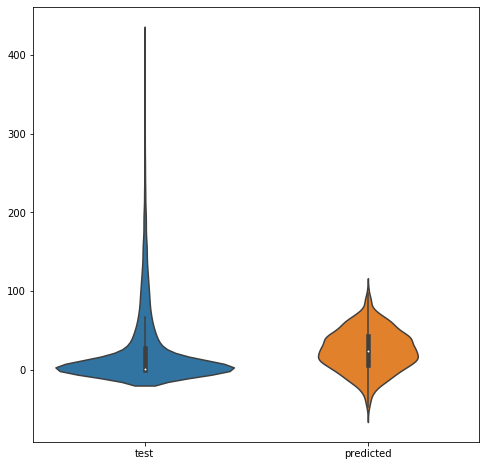

In [39]:
#clasifying the rain, to 

#pred_test_rainfall.plot()
plt.rcParams["figure.figsize"] = (8,8)
sns.violinplot( data=pred_test_rainfall)

Text(0.5, 0, '#')

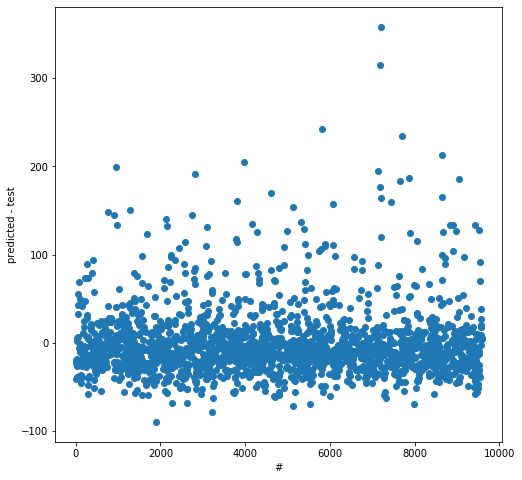

In [44]:
#Paolo: it is insigthful also to plot the difference
plt.plot(pred_test_rainfall.test- pred_test_rainfall.predicted, 'o')
plt.ylabel("predicted - test")
plt.xlabel("#")

## Comments Paolo
Sara, good work you understand the basic principles of machine learning, especially the train/test part where you train and test the model on separate parts of the dataset. A couple of comments

- It could be insightful also to calculate performance of the model on the train set and compare it to performance on the test set. It would be helpful to detect potential overfit
- You mention that you want to work with unsupervised learning but then you use linear regression. Linear Regression is a supervised method. Kmeans clustering is an example of an unsupervised algorithm
- Interesting violin plots to study distributions, have also a look at a simpler plot I made
- Good that you try different parameters, an option that should compact you results is to loop over a range of possible parameters and selecting the best, as opposed to manual testing